In [81]:
import numpy as np 
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

## Читаем данные

In [82]:
vaccines = pd.read_csv("vaccinations.csv")
vaccines["date"] = (pd.to_datetime(vaccines["date"])).dt.date
vaccines = vaccines.groupby(["date"])["daily_vaccinations"].sum().reset_index()
vaccines.columns = ["date", "vaccinationsCount"]
vaccines

,date,vaccinationsCount
0,2020-12-02,0.0
1,2020-12-03,0.0
2,2020-12-04,0.0
3,2020-12-05,0.0
4,2020-12-06,0.0
...,...,...
265,2021-08-24,141618411.0
266,2021-08-25,144342936.0
267,2021-08-26,147456968.0
268,2021-08-27,148928388.0


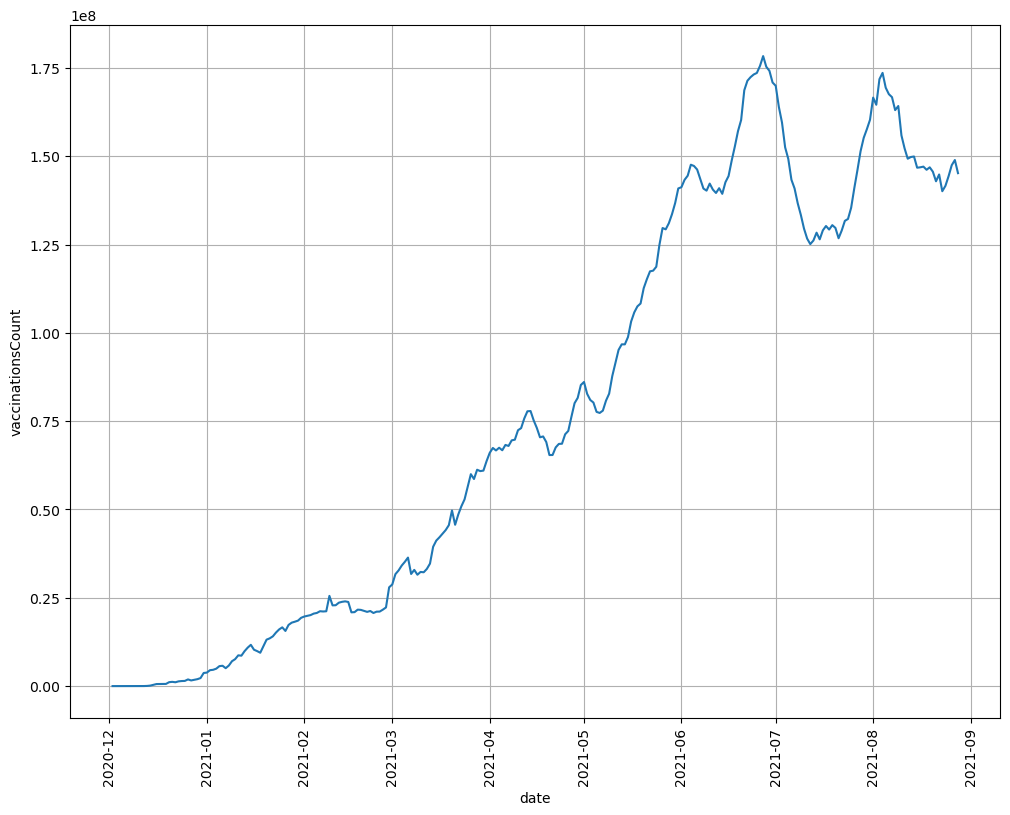

In [83]:
f, ax = plt.subplots(1, 1, figsize=(12, 9))
sns.lineplot(x="date", y="vaccinationsCount", data=vaccines)
plt.xticks(rotation=90)
ax.grid()
plt.show()

In [84]:
tweets = pd.read_csv("vaccination_all_tweets.csv")
tweets["date"] = pd.to_datetime(tweets["date"]).dt.date
tweets = tweets.groupby(["date"])["text"].count().reset_index()
tweets.columns = ["date", "tweetsCount"]
tweets

,date,tweetsCount
0,2020-12-12,63
1,2020-12-13,98
2,2020-12-14,137
3,2020-12-15,150
4,2020-12-16,144
...,...,...
314,2021-11-19,846
315,2021-11-20,765
316,2021-11-21,629
317,2021-11-22,612


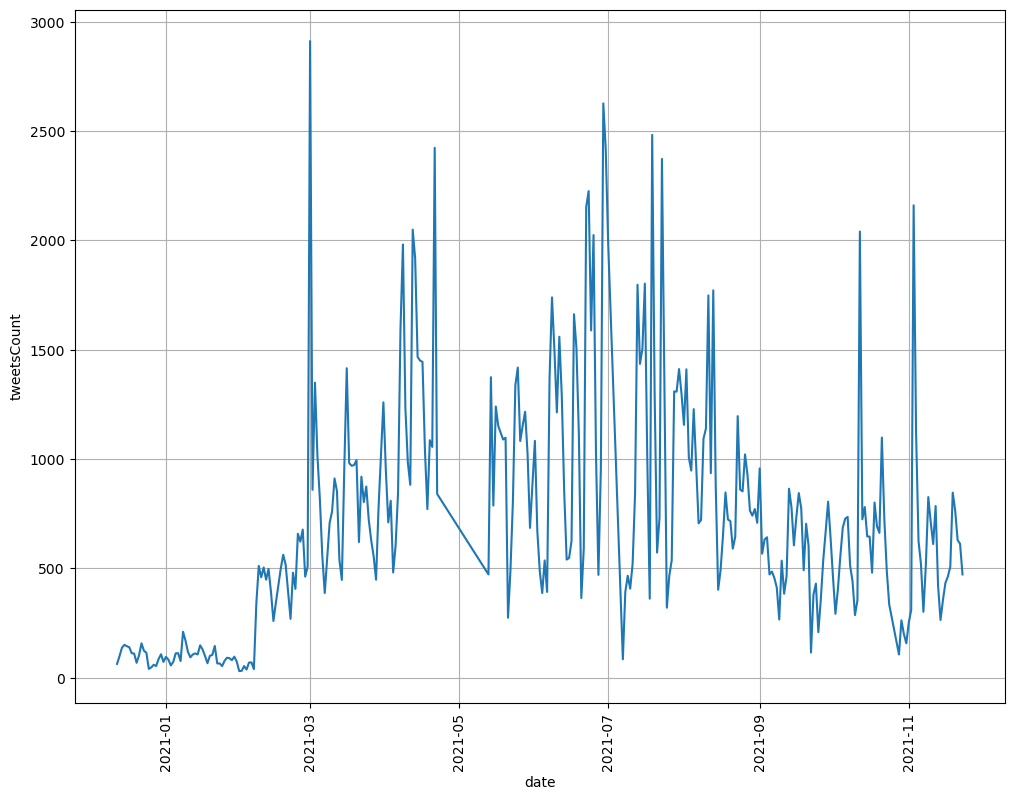

In [85]:
f, ax = plt.subplots(1, 1, figsize=(12, 9))
sns.lineplot(x="date", y="tweetsCount", data=tweets)
plt.xticks(rotation=90)
ax.grid()
plt.show() 

## Тест Гренджера

In [102]:
data = pd.merge(tweets, vaccines, on="date")
data

,date,tweetsCount,vaccinationsCount
0,2020-12-12,63,15297.0
1,2020-12-13,98,50750.0
2,2020-12-14,137,139627.0
3,2020-12-15,150,371204.0
4,2020-12-16,144,580596.0
...,...,...,...
230,2021-08-24,860,141618411.0
231,2021-08-25,852,144342936.0
232,2021-08-26,1021,147456968.0
233,2021-08-27,928,148928388.0


### Прямой тест

Нуль гипотеза: пусть X (тивиты) НЕ являются причиной Y (вакцины)

In [110]:
grangercausalitytests(pd.concat([data["tweetsCount"], data["vaccinationsCount"]], axis=1), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1025  , p=0.0001  , df_denom=225, df_num=3
ssr based chi2 test:   chi2=21.9704 , p=0.0001  , df=3
likelihood ratio test: chi2=20.9914 , p=0.0001  , df=3
parameter F test:         F=7.1025  , p=0.0001  , df_denom=225, df_num=3


{3: ({'ssr_ftest': (7.1024862969835265, 0.0001400444231899132, 225.0, 3),
   'ssr_chi2test': (21.970357612002374, 6.616409903570136e-05, 3),
   'lrtest': (20.99140320467086, 0.00010570984587596594, 3),
   'params_ftest': (7.102486296490156, 0.00014004442328054525, 225.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

Т.к. $p < 0.05$, то можно отклонить нуль гипотезу. Получается, что знание о количестве твитов 
может быть полезным при предсказании количества вакцинированных. 

### Обратный тест

In [ ]:
Нуль гипотеза: пусть X (вакцины) НЕ являются причиной Y (тивиты)

In [111]:
grangercausalitytests(pd.concat([data["vaccinationsCount"], data["tweetsCount"]], axis=1), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5576  , p=0.2006  , df_denom=225, df_num=3
ssr based chi2 test:   chi2=4.8181  , p=0.1856  , df=3
likelihood ratio test: chi2=4.7688  , p=0.1895  , df=3
parameter F test:         F=1.5576  , p=0.2006  , df_denom=225, df_num=3


{3: ({'ssr_ftest': (1.5575772125746323, 0.20055051673050164, 225.0, 3),
   'ssr_chi2test': (4.81810551089753, 0.1856112784729129, 3),
   'lrtest': (4.768757100899165, 0.189534402533642, 3),
   'params_ftest': (1.5575772125745624, 0.20055051673052013, 225.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

Значение $p > 0.05$, поэтому мы не можем отвергнуть нулевую гипотезу.

Согласно тесту Гренджера нельзя сказать, что количество вакцинаций причинно-следственно связано с количеством твитов